In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import control as ct
from pytz import timezone

import sys

sys.path.append("../../../")

from utils.plot import (
    config_matplotlib,
    figsize,
    fig_save_and_show,
    plot_events_data,
)
from utils.optimization import (
    save_model_params_to_json,
    load_model_params_from_json,
)
from utils.data import (
    export_dataframe_to_latex,
)
from utils.sensitivity_analysis import (
    describe_param_with_uniform_distribution,
    describe_param_with_log_uniform_distribution,
    describe_param_with_triangular_distribution,
    describe_param_with_normal_distribution,
    describe_param_with_truncated_normal_distribution,
    describe_param_with_log_normal_distribution,
    wrapped_model_function,
    create_problem_spec_and_sample,
    plot_sampled_distribuitions,
    evaluate_problem,
    analyze_time_step,
    analyze_problem,
    sobol_sensitivity_analysis_from_model_params_to_outputs,
    plot_sensitivity_analysis,
    plot_sensitivity_analysis_heatmaps,
    get_region_mean,
    plot_sensitivity_analysis_bars,
)
from utils.models import eval_poly, lut_interp

import warnings

warnings.filterwarnings("ignore")

config_matplotlib()
latex_img_path = "/home/joaoantoniocardoso/workspace_TCC/repo/tcc/imgs/"
latex_tex_path = "/home/joaoantoniocardoso/workspace_TCC/repo/tcc/tex/"

# Sensitivity Analysis


In [ ]:
from model import Battery1RC as Battery

Battery.build({})

<NonlinearIOSystem battery: ['batt_i'] -> ['batt_v', 'batt_z', 'batt_ocv']>

In [ ]:
batt_name = "D35"
cell_amps_hour = 48
series_cells = 3
parallel_cells = 1
cell_voltage = 12
nominal_Q = parallel_cells * cell_amps_hour  # Capacity, in Amper-hour
initial_SOC = 1
nominal_voltage = series_cells * cell_voltage
ocv_params = load_model_params_from_json("battery_ocv_params.json")
batt_k_V_OC_coeffs = ocv_params["batt_k_V_OC_coeffs"]
# batt_ocv_lut = ocv_params['batt_ocv_lut']

battery_params = {
    "batt_N_S": series_cells,
    "batt_eta": 1,
    "batt_Q": cell_amps_hour * 3600,
    "batt_k_V_OC_coeffs": batt_k_V_OC_coeffs,
    "batt_R_0_coeffs": [0.005],
    "batt_R_1_coeffs": [0.1],
    "batt_C_1_coeffs": [10000],
}

model_params = battery_params
model_params

{'batt_N_S': 3,
 'batt_eta': 1,
 'batt_Q': 172800,
 'batt_k_V_OC_coeffs': array([10.78645833,  3.58638935, -3.07530114,  1.61637218]),
 'batt_R_0_coeffs': [0.005],
 'batt_R_1_coeffs': [0.1],
 'batt_C_1_coeffs': [10000]}

In [ ]:
def _estimate_open_circuit_voltage(params, batt_z):
    if "batt_ocv_lut" in params:
        return float(lut_interp(params["batt_ocv_lut"], batt_z))
    if "batt_k_V_OC_coeffs" in params:
        coeffs = params["batt_k_V_OC_coeffs"]
        try:
            return float(lut_interp(coeffs, batt_z))
        except Exception:
            return float(eval_poly(coeffs, batt_z))
    return 0.0


def model_function(T, U, X0, **params):
    return ct.input_output_response(
        Battery.build(params=params),
        T=T,
        U=U,
        X0=X0,
        solve_ivp_method="Radau",
    ).to_pandas()


def battery_sensitivity_analysis_step_response(
    params_description: dict,
    current_step: float,
    samples: int,
    do_plot=True,
):
    model_class = Battery
    model_tmp = model_class.build(model_params)

    T = np.linspace(0, 200, 201, endpoint=True)

    U = np.empty([model_tmp.ninputs, len(T)]) * np.nan
    U[model_tmp.input_labels.index("batt_i")] = current_step

    batt_z_0 = 0.9
    batt_v_0 = model_params.get("batt_N_S", 1) * _estimate_open_circuit_voltage(
        model_params, batt_z_0
    )

    X0 = model_class.initial_state(
        X0={
            "batt_z": batt_z_0,
            "batt_v": batt_v_0,
        },
        U0=U[:, 0],
        params=model_params,
    )

    df_sa, problem = sobol_sensitivity_analysis_from_model_params_to_outputs(
        params_description=params_description,
        T=T,
        U=U,
        X0=X0,
        model_function=model_function,
        model_class=model_class,
        model_params=model_params,
        samples=samples,
        calc_second_order=False,
        seed=42,
        nprocs=32,
    )

    df_steady_state_mean = get_region_mean(df_sa, t_start=180, t_end=200)

    export_dataframe_to_latex(
        filename=f"{latex_tex_path}/PNGV_1rc_sensitivity_analysis_{current_step}.tex",
        label=f"table:PNGV_1rc_sensitivity_analysis_{current_step}",
        caption="Índices de Sobol em regime permanente",
        df_steady_state_mean=df_steady_state_mean,
    )

    if do_plot:
        display(df_steady_state_mean)

        fig_save_and_show(
            filename=f"{latex_img_path}/PNGV_1rc_sensitivity_analysis_distributions.pdf",
            save_title="Distribuição dos valores para cada fator",
            show_title="Distribution of the values for each factor",
            fig=plot_sampled_distribuitions(problem),
            ncols=3,
        )

        for output in df_sa["output"].unique():
            fig_save_and_show(
                filename=f"{latex_img_path}/PNGV_1rc_sensitivity_analysis_{current_step}_{output}.pdf",
                save_title=f"Índices de Sobol para a saída {output} durante o tempo, com degrau de {current_step} [A], com {samples} amostras",
                show_title=f"Sobol Indices for the output {output} over time with step of {current_step} [A], with {samples} samples",
                fig=plot_sensitivity_analysis(df_sa, output=output),
                ncols=3,
            )

        for output in df_sa["output"].unique():
            fig_save_and_show(
                filename=f"{latex_img_path}/PNGV_1rc_sensitivity_analysis_heatmaps_{current_step}_{output}.pdf",
                save_title=f"Índices de Sobol para a saída {output} durante o tempo, com degrau de {current_step} [A], com {samples} amostras",
                show_title=f"Sobol Indices for the output {output} over time with step of {current_step} [A], with {samples} samples",
                fig=plot_sensitivity_analysis_heatmaps(df_sa, output=output),
                ncols=3,
            )

        for output in df_sa["output"].unique():
            fig_save_and_show(
                filename=f"{latex_img_path}/PNGV_1rc_sensitivity_analysis_bars_{current_step}_{output}.pdf",
                save_title=f"Índices de Sobol para a saída {output} em regime permanente, com degrau de {current_step} [A], com {samples} amostras",
                show_title=f"Sobol Indices for the output {output} at steady-state with step of {current_step} [A], with {samples} samples",
                fig=plot_sensitivity_analysis_bars(df_steady_state_mean, output=output),
                ncols=3,
            )

    return df_sa, problem

In [ ]:
# Setting all uncertainties to be x%
u_batt_R_0 = 1 / 100
u_batt_R_1 = 1 / 100
u_batt_C_1 = 1 / 100
u_batt_Q = 1 / 100
u_batt_eta = 1 / 100

pool
chain


value          conf
output   factor            metric                            
batt_ocv batt_eta          S1      4.996205e-01  1.110746e-01
                           ST      4.997173e-01  8.193070e-02
         batt_R_1_coeffs_0 S1      6.594754e-15  2.828994e-14
                           ST      2.804633e-26  1.096432e-26
         batt_R_0_coeffs_0 S1      0.000000e+00  0.000000e+00
                           ST      0.000000e+00  0.000000e+00
         batt_Q            S1      5.006688e-01  1.090692e-01
                           ST      5.006997e-01  7.566116e-02
         batt_C_1_coeffs_0 S1      8.082100e-16  2.669700e-14
                           ST      2.399632e-26  1.011174e-26
batt_v   batt_eta          S1      1.007036e-02  1.830514e-02
                           ST      1.036446e-02  1.733680e-03
         batt_R_1_coeffs_0 S1      9.032641e-01  1.481652e-01
                           ST      9.032829e-01  1.236083e-01
         batt_R_0_coeffs_0 S1      7.592892e-02  5.008745e-02
                           ST      7.555584e-02  1.285976e-02
         batt_Q            S1      1.035714e-02  1.827948e-02
                           ST      1.038484e-02  1.842024e-03
         batt_C_1_coeffs_0 S1     -2.272592e-04  7.616446e-04
                           ST      2.503529e-05  6.114304e-06
batt_z   batt_eta          S1      4.996547e-01  1.110774e-01
                           ST      4.997623e-01  8.194295e-02
         batt_R_1_coeffs_0 S1      8.363792e-15  1.014428e-14
                           ST      3.744215e-27  7.797842e-28
         batt_R_0_coeffs_0 S1      0.000000e+00  0.000000e+00
                           ST      0.000000e+00  0.000000e+00
         batt_Q            S1      5.006729e-01  1.090571e-01
                           ST      5.006998e-01  7.564634e-02
         batt_C_1_coeffs_0 S1      1.262786e-15  9.720416e-15
                           ST      3.323524e-27  6.431812e-28

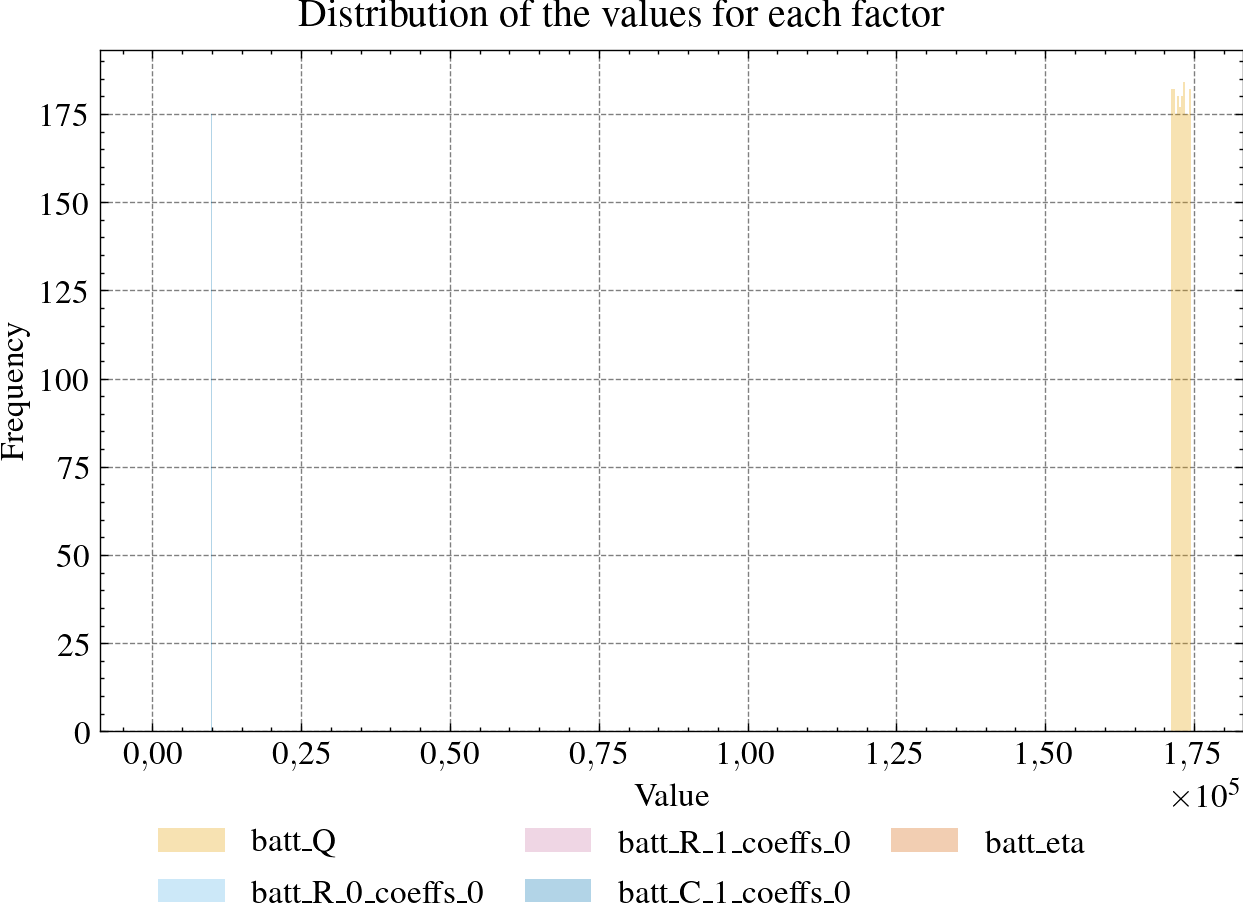

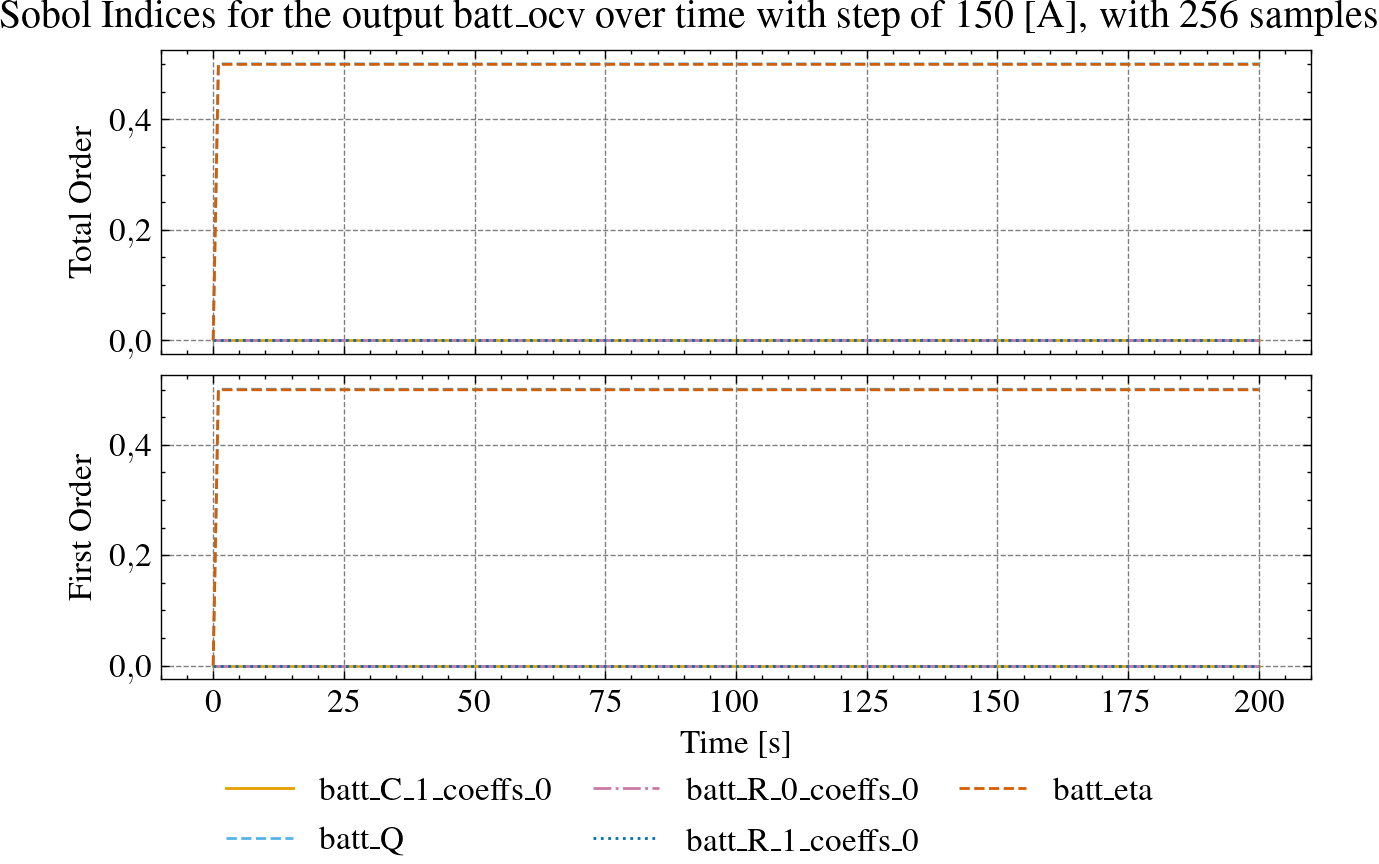

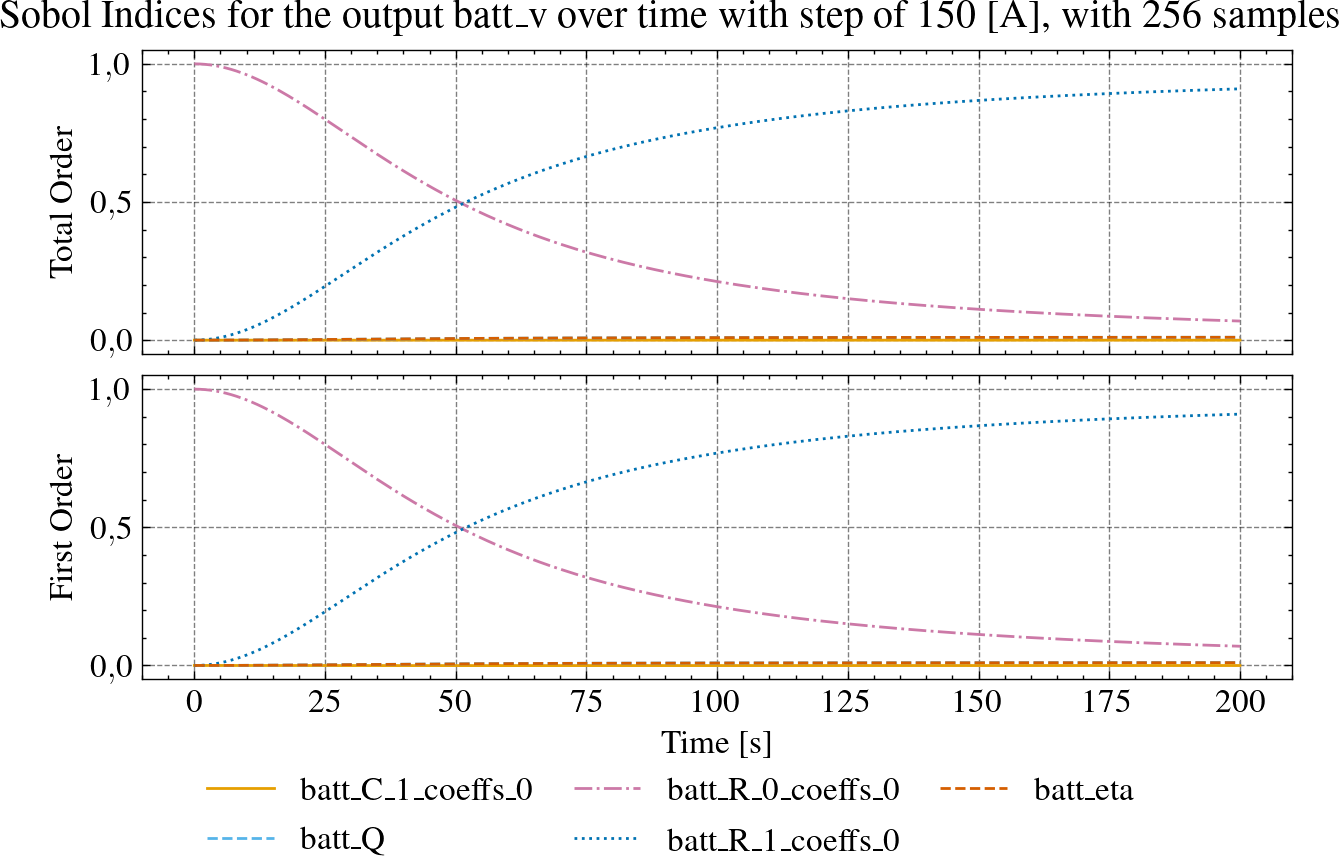

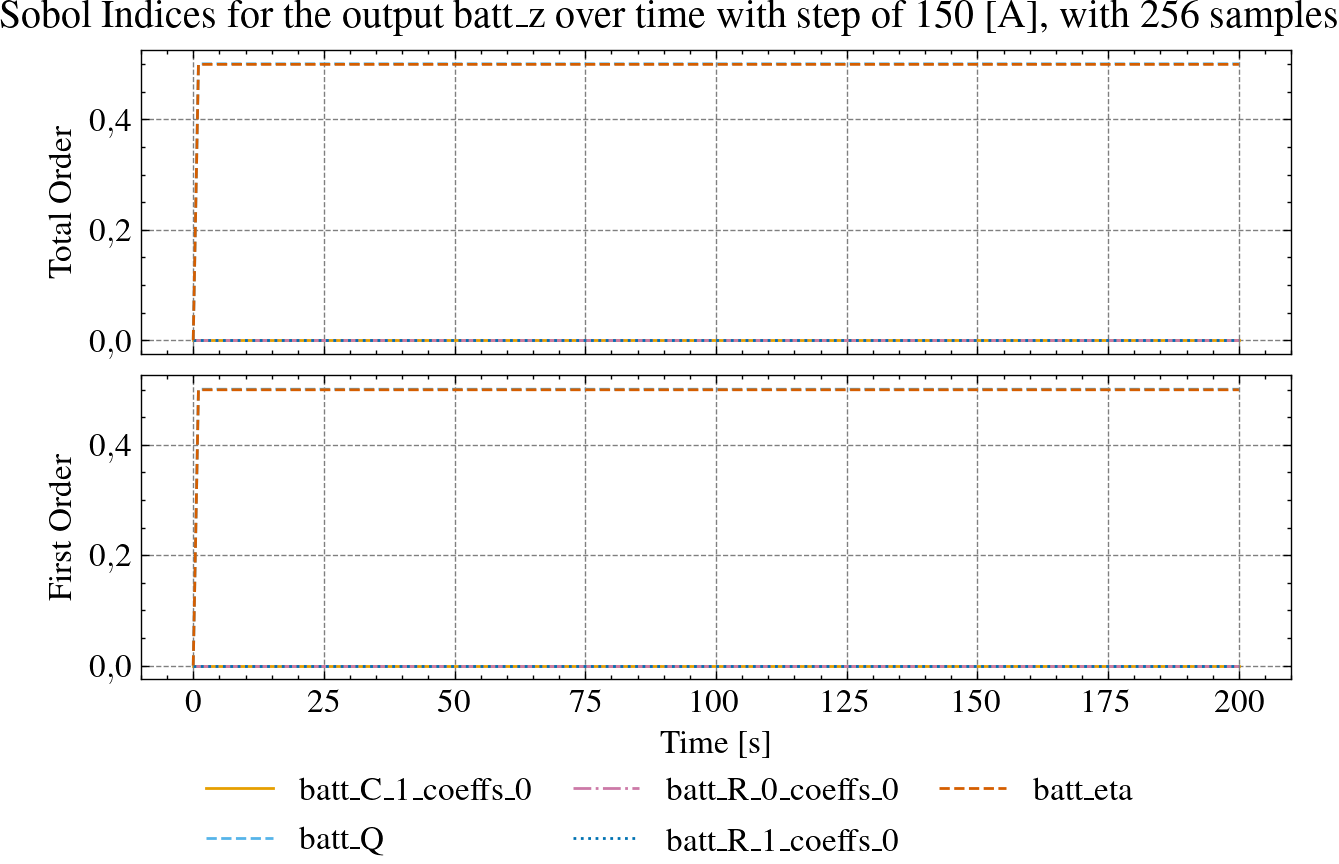

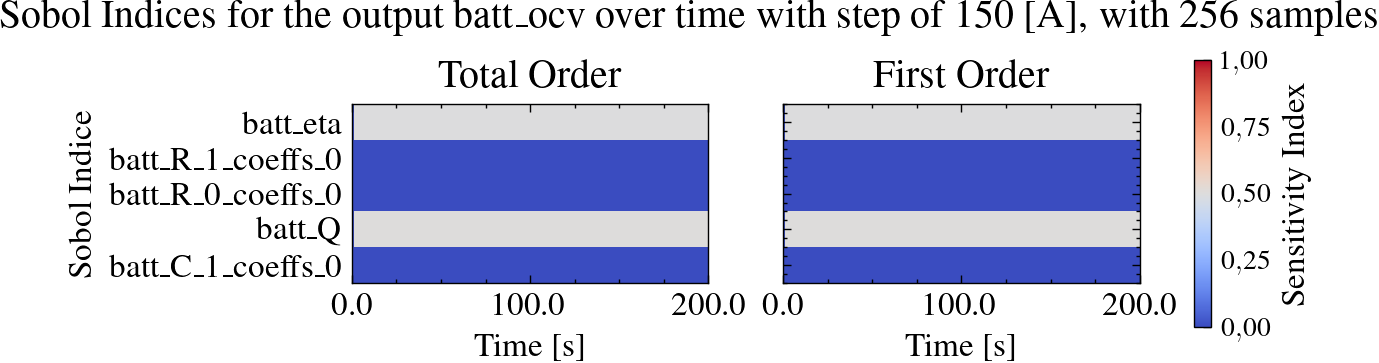

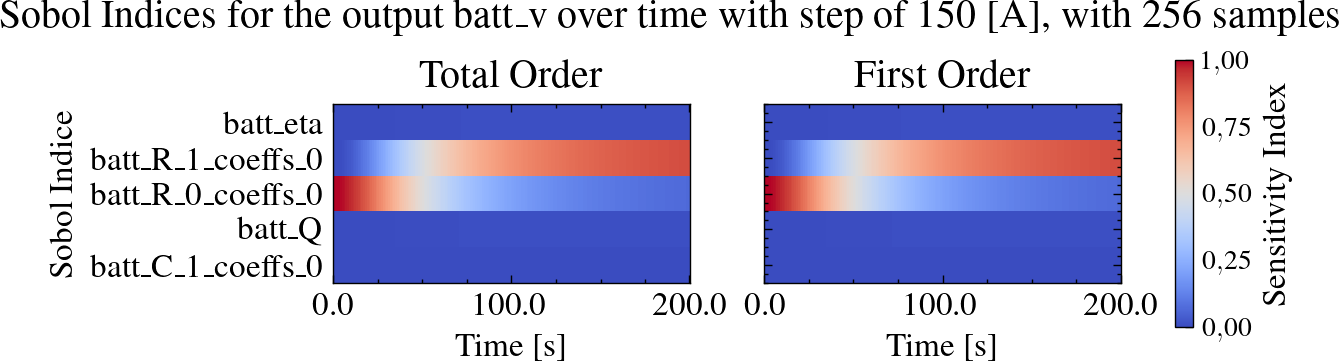

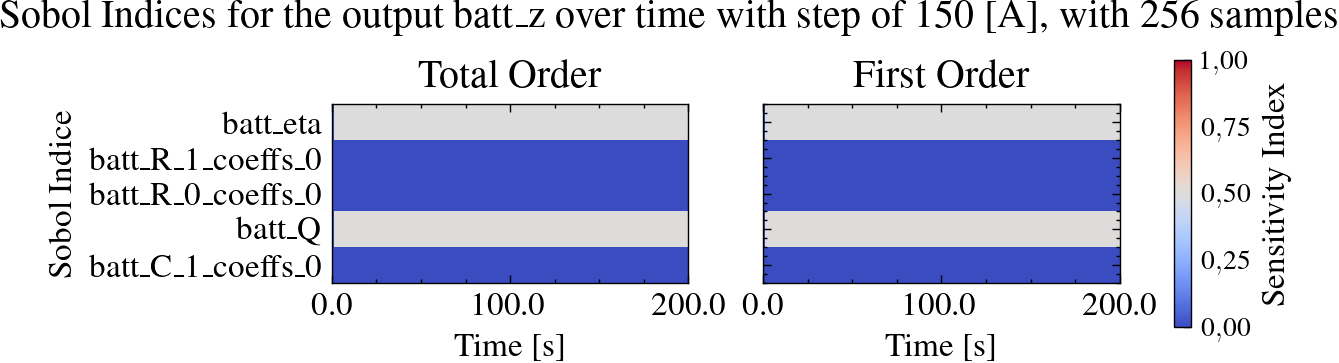

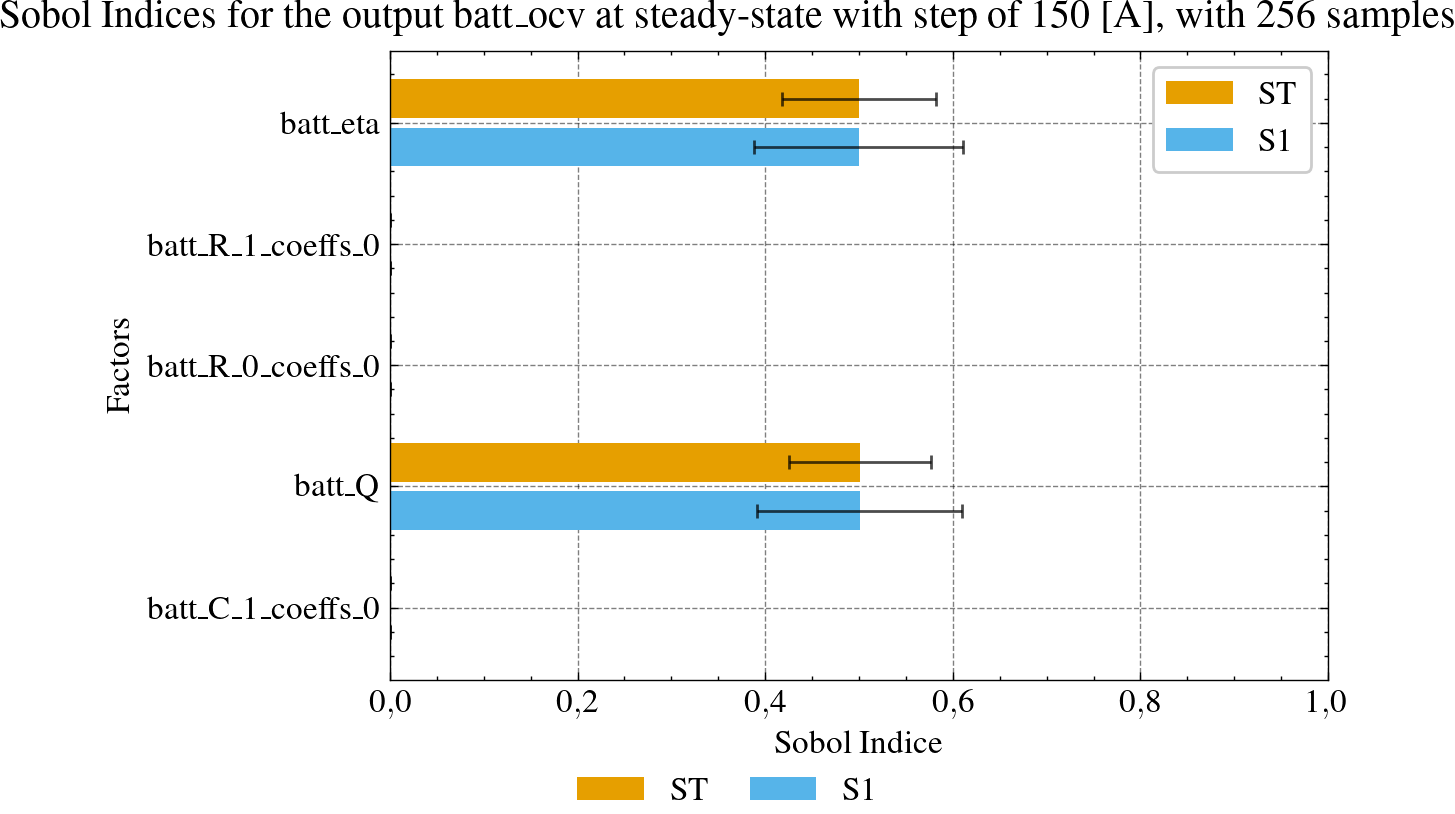

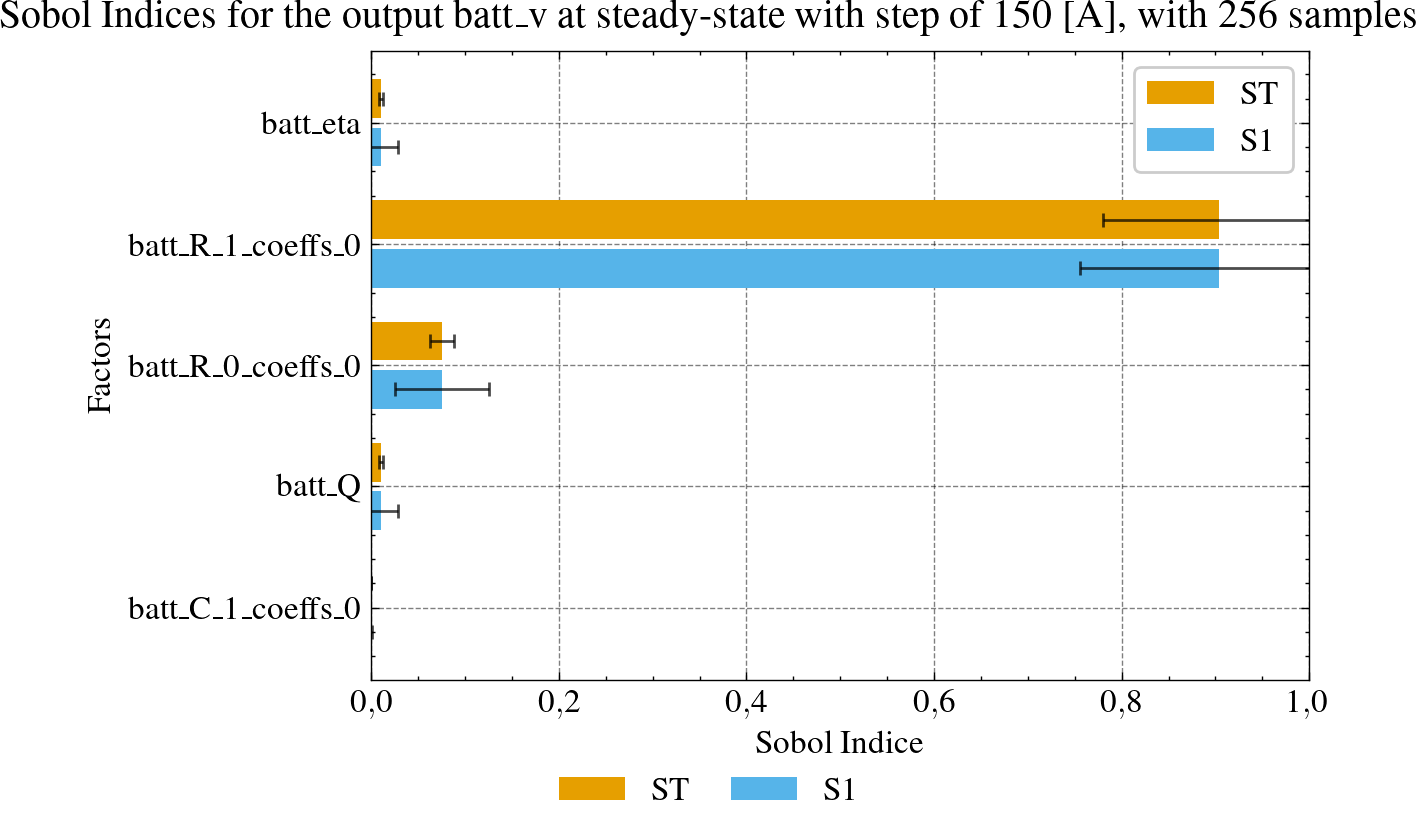

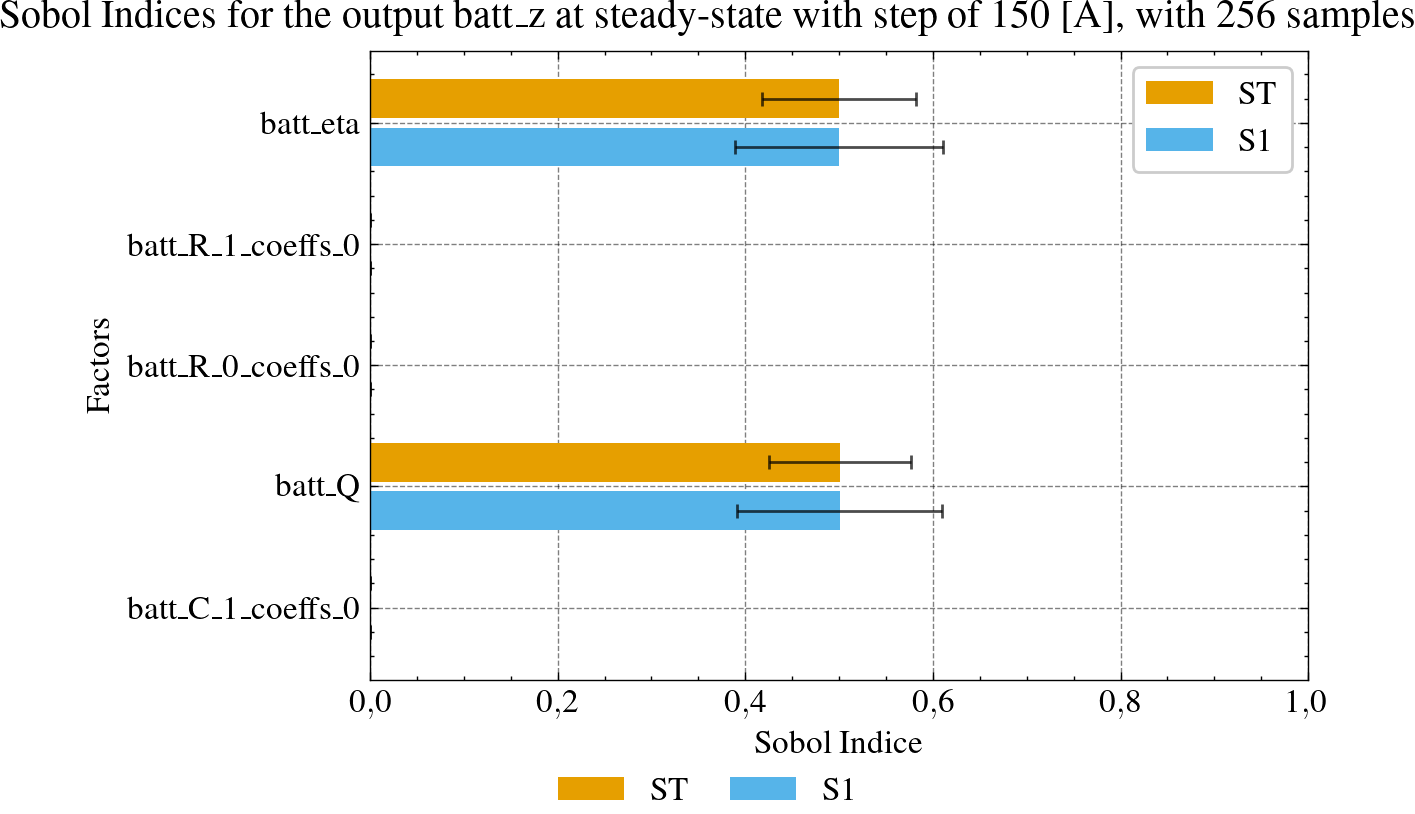

pool
chain


value          conf
output   factor            metric                            
batt_ocv batt_eta          S1      4.996712e-01  1.110788e-01
                           ST      4.997841e-01  8.194891e-02
         batt_R_1_coeffs_0 S1     -2.283778e-14  1.056802e-13
                           ST      3.921677e-25  1.721645e-25
         batt_R_0_coeffs_0 S1      0.000000e+00  0.000000e+00
                           ST      0.000000e+00  0.000000e+00
         batt_Q            S1      5.006749e-01  1.090512e-01
                           ST      5.007000e-01  7.563920e-02
         batt_C_1_coeffs_0 S1     -3.667339e-14  1.108491e-13
                           ST      4.129387e-25  1.712366e-25
batt_v   batt_eta          S1      1.510534e-02  2.228620e-02
                           ST      1.545827e-02  2.590317e-03
         batt_R_1_coeffs_0 S1      8.938894e-01  1.463447e-01
                           ST      8.939216e-01  1.231381e-01
         batt_R_0_coeffs_0 S1      7.512881e-02  4.989951e-02
                           ST      7.477421e-02  1.278593e-02
         batt_Q            S1      1.545369e-02  2.230091e-02
                           ST      1.548660e-02  2.758466e-03
         batt_C_1_coeffs_0 S1     -2.235495e-04  7.569321e-04
                           ST      2.477587e-05  6.048263e-06
batt_z   batt_eta          S1      4.996547e-01  1.110774e-01
                           ST      4.997623e-01  8.194295e-02
         batt_R_1_coeffs_0 S1     -1.418288e-14  3.978832e-14
                           ST      5.529722e-26  1.006276e-26
         batt_R_0_coeffs_0 S1      0.000000e+00  0.000000e+00
                           ST      0.000000e+00  0.000000e+00
         batt_Q            S1      5.006729e-01  1.090571e-01
                           ST      5.006998e-01  7.564634e-02
         batt_C_1_coeffs_0 S1     -4.011436e-14  3.652479e-14
                           ST      5.173834e-26  1.008904e-26

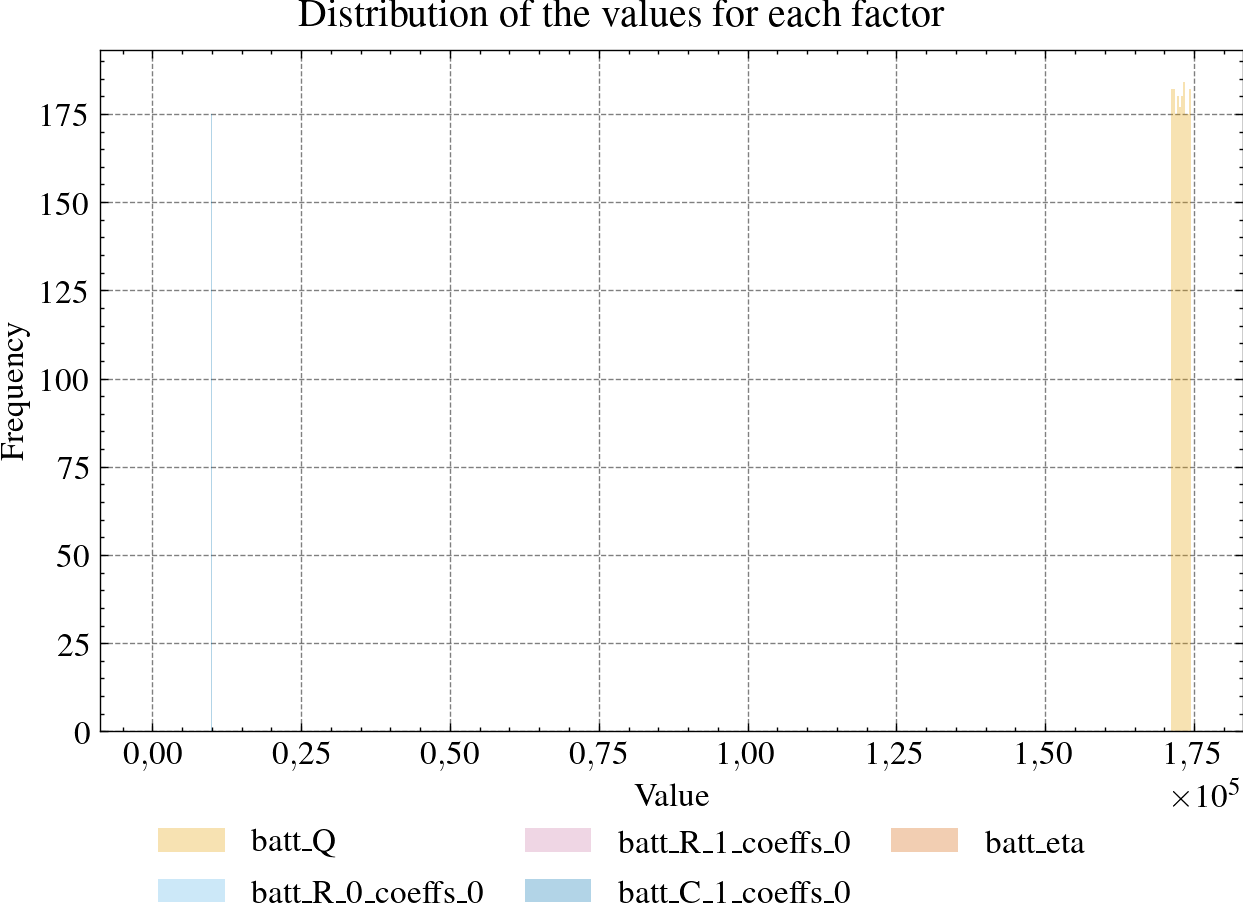

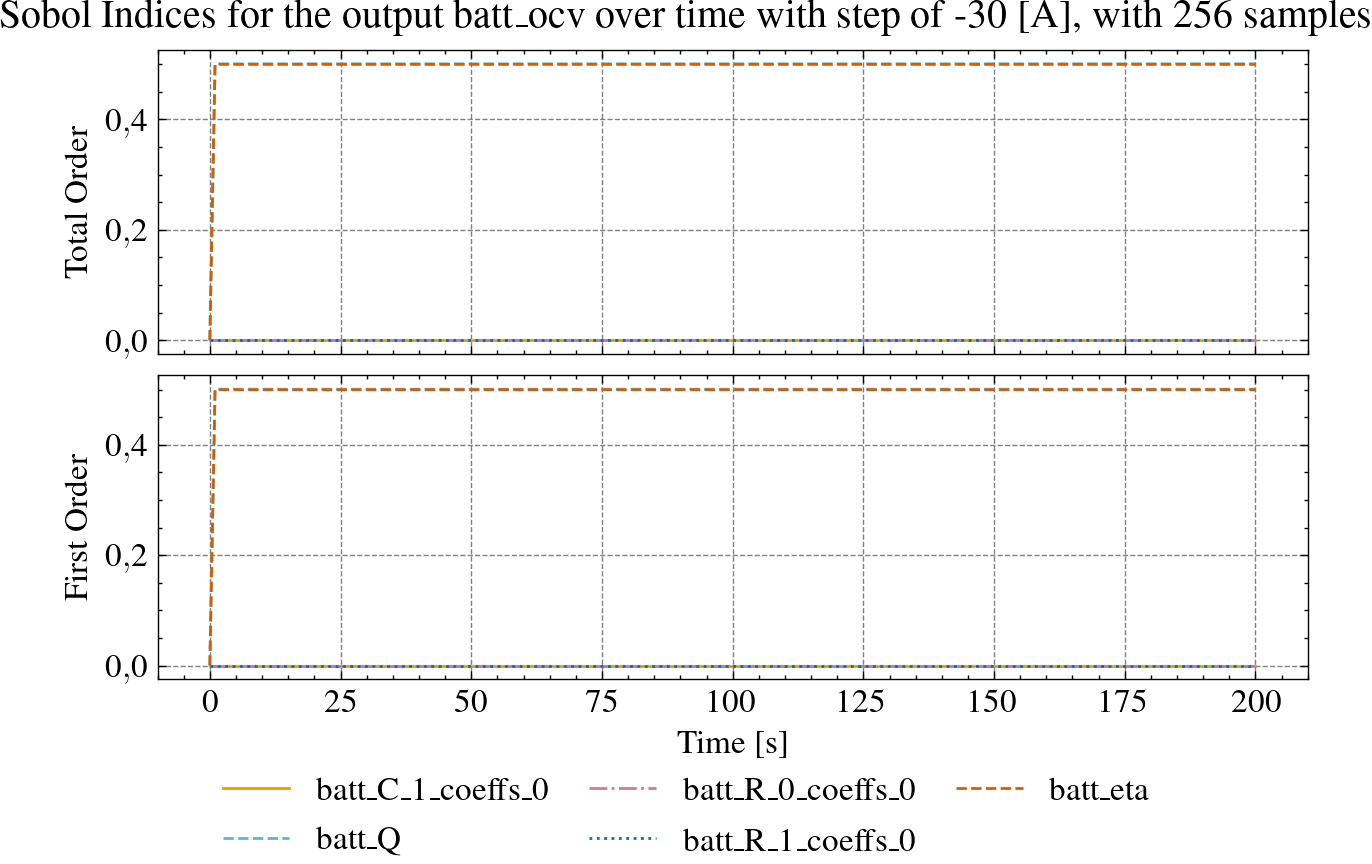

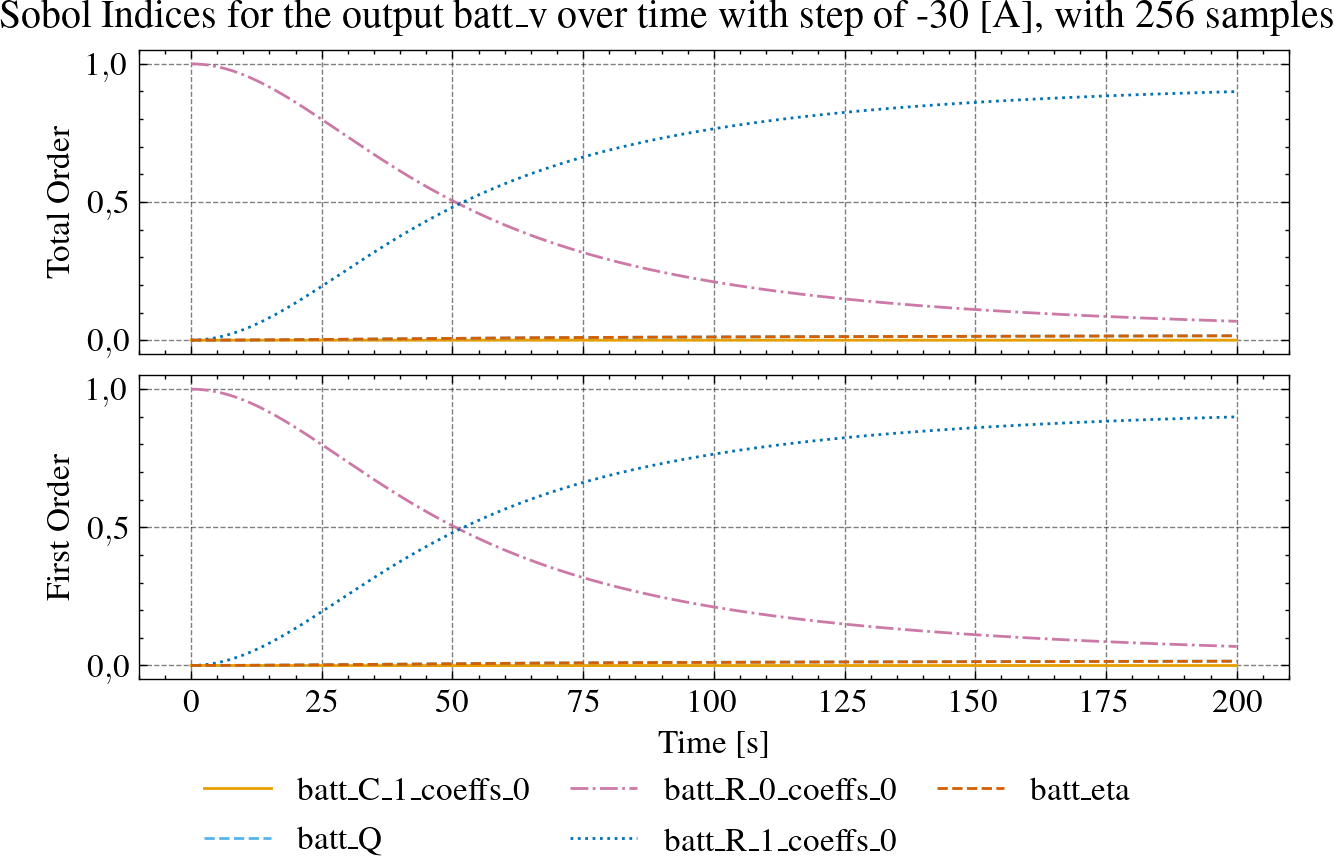

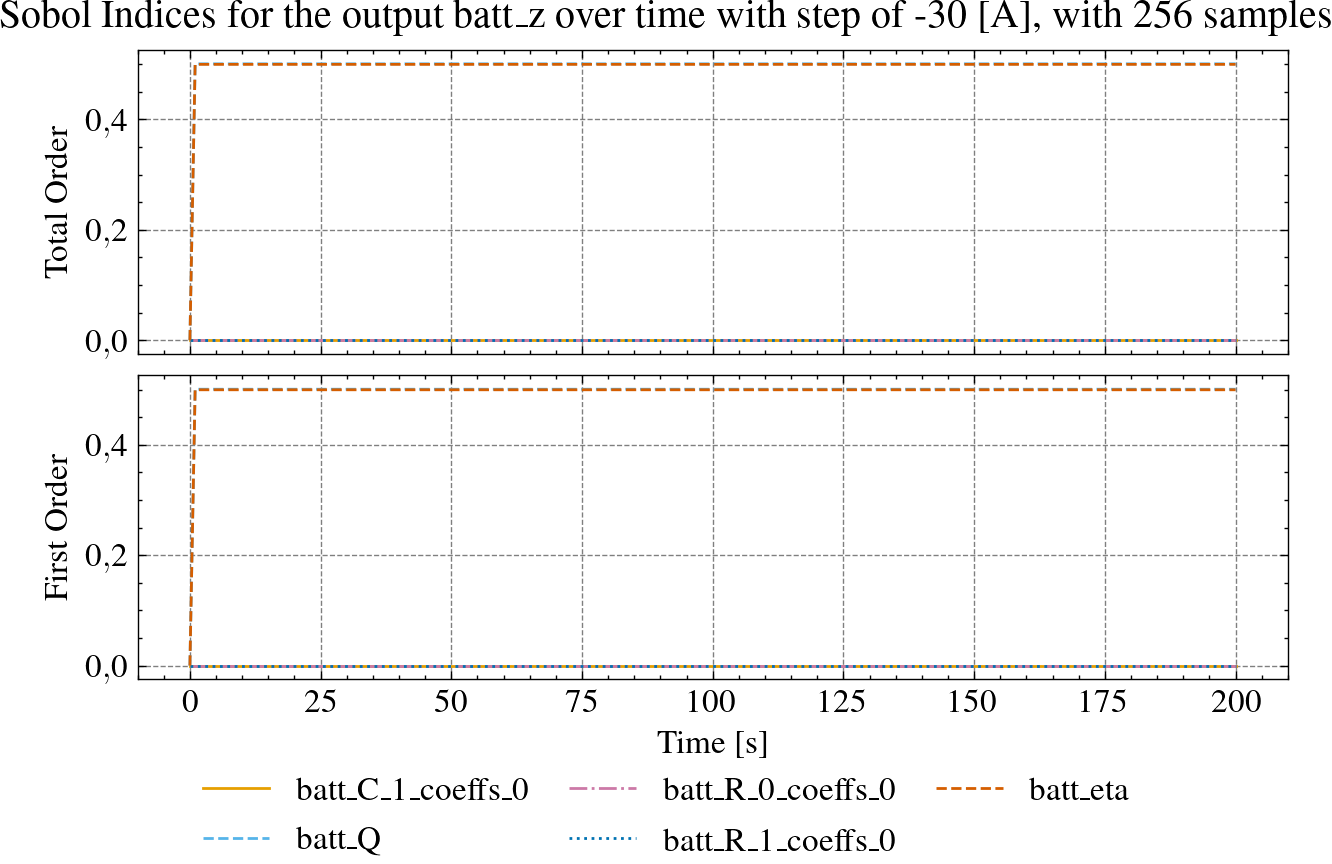

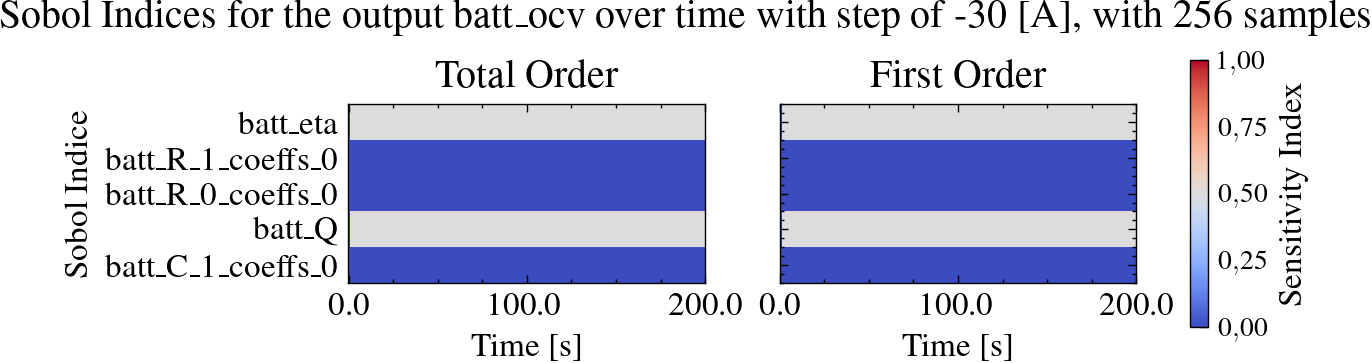

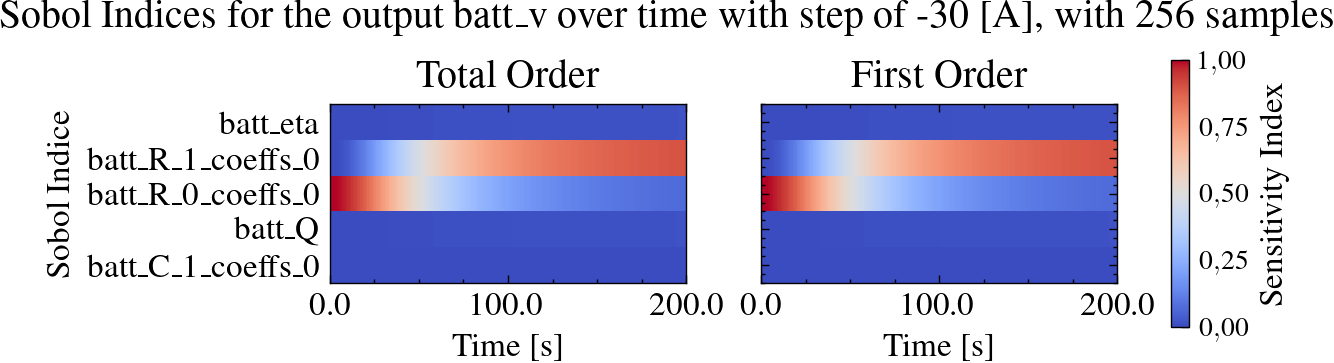

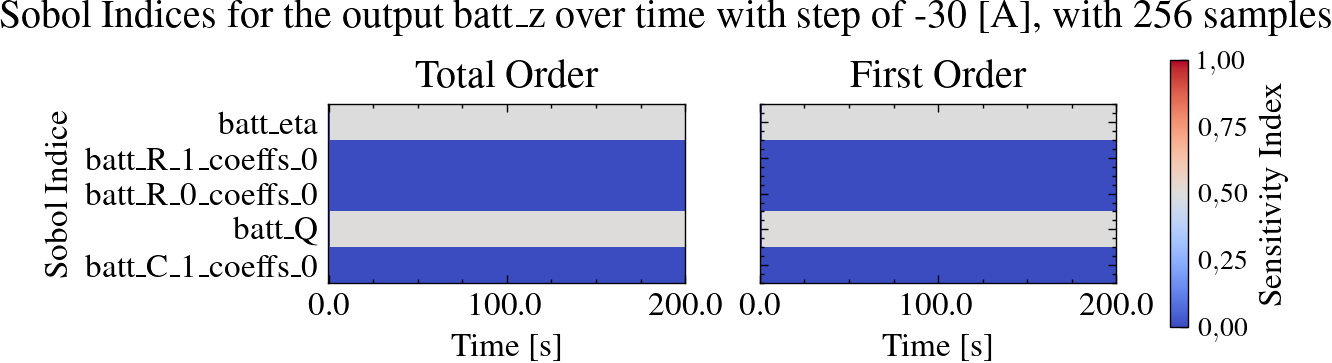

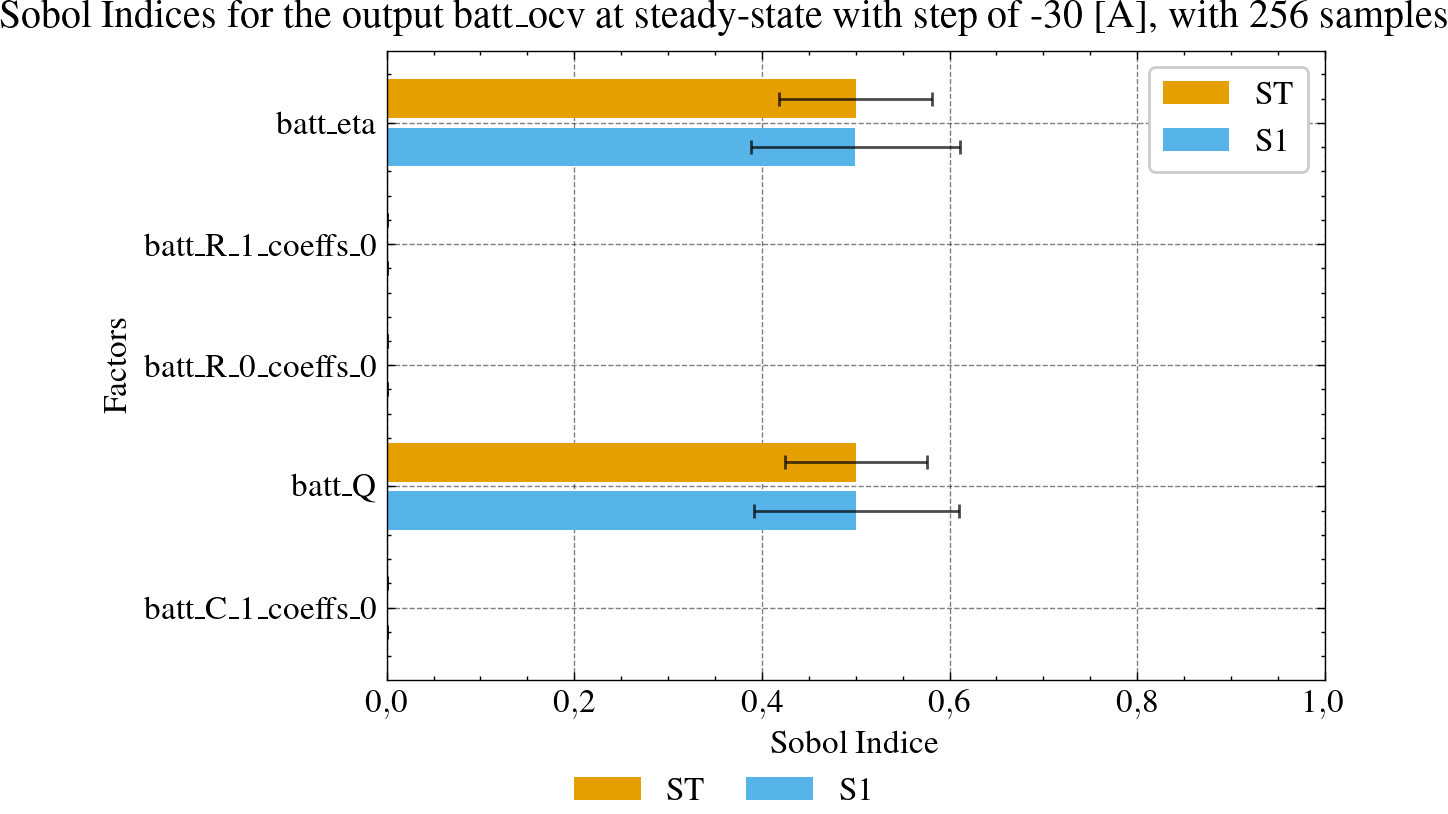

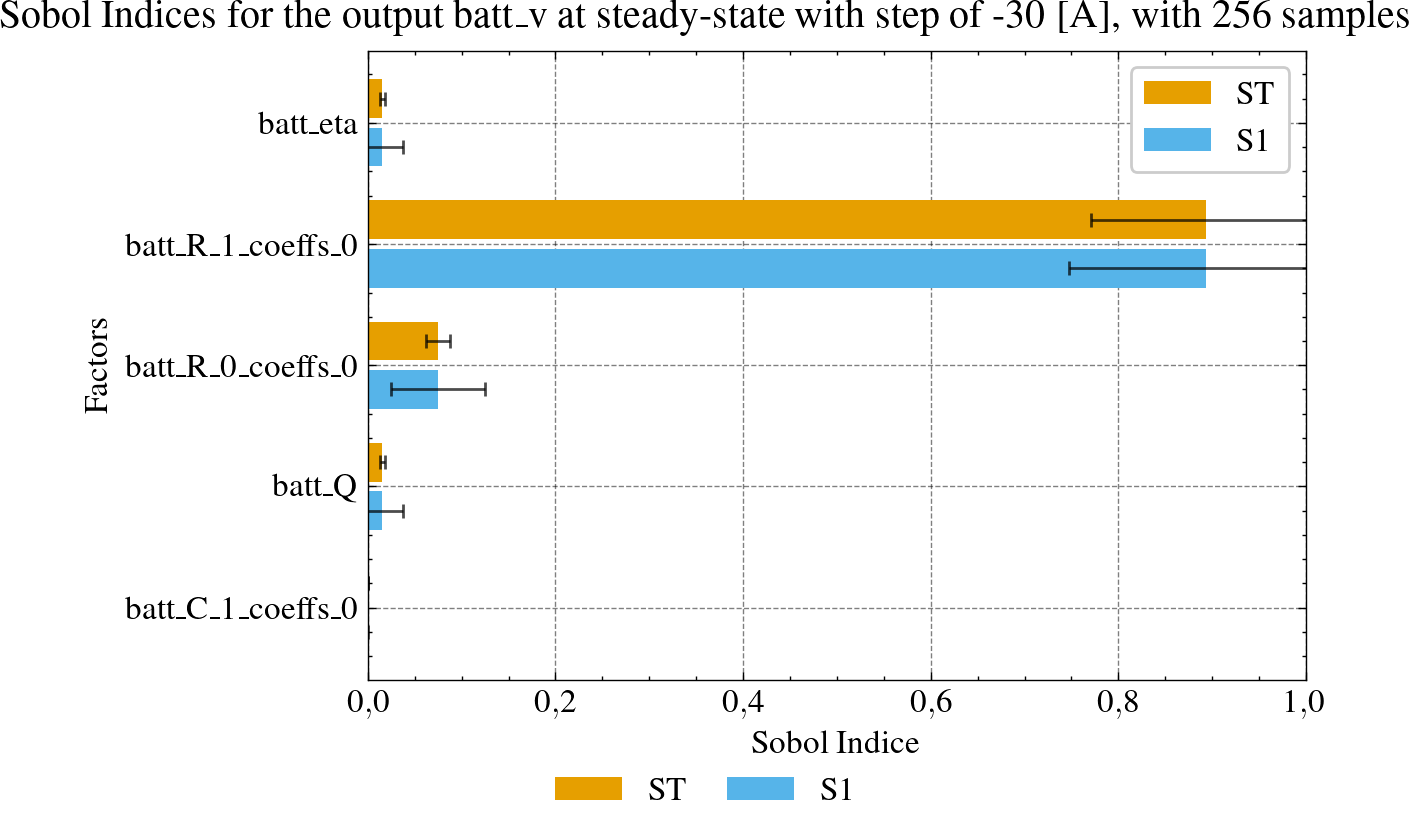

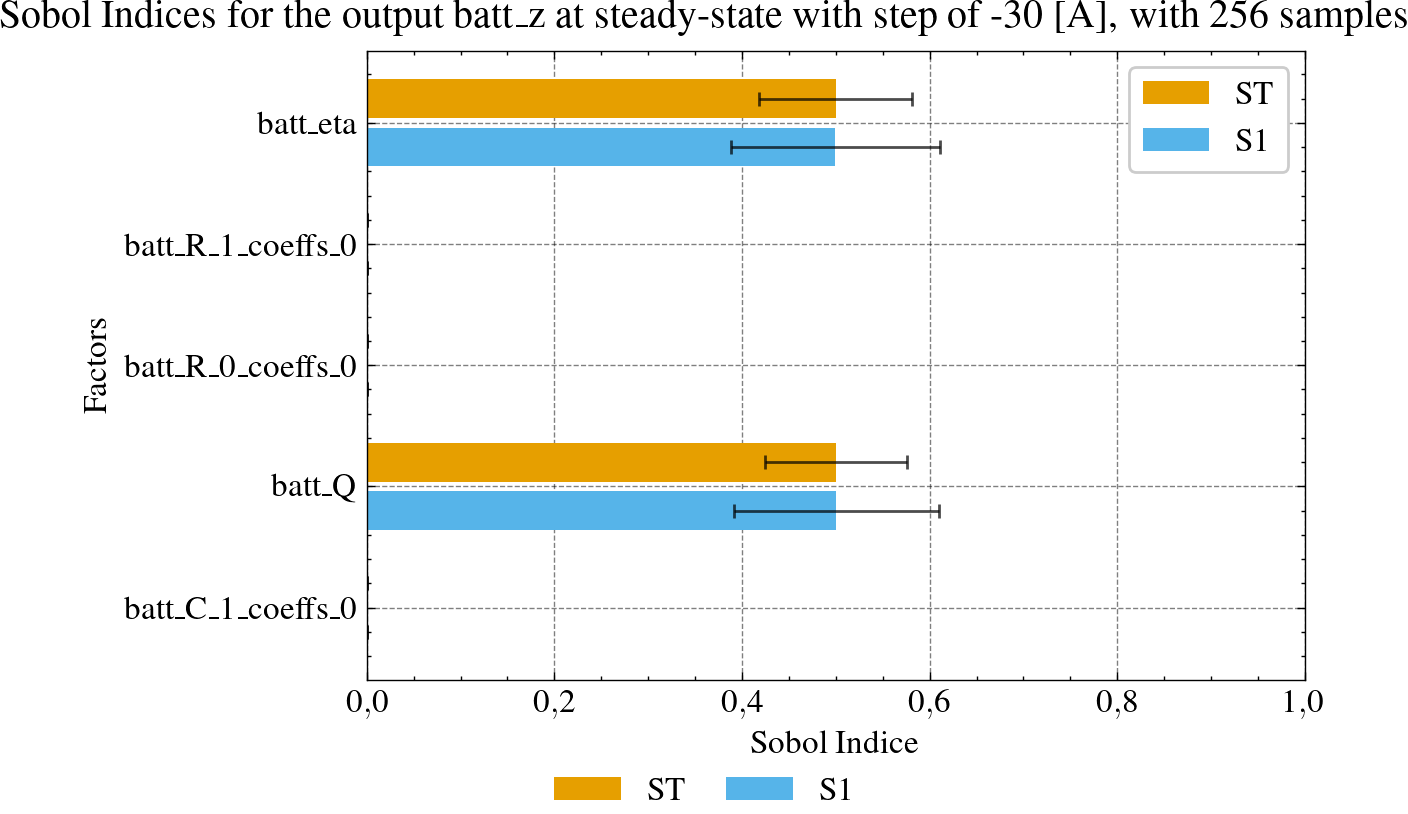

CPU times: user 14.7 s, sys: 12.7 s, total: 27.3 s
Wall time: 22.6 s


In [7]:
%%time

params_description = {
    'batt_Q': describe_param_with_uniform_distribution(lower=model_params['batt_Q']*(1-u_batt_Q), upper=model_params['batt_Q']*(1+u_batt_Q)),
    'batt_R_0_coeffs_0': describe_param_with_uniform_distribution(lower=model_params['batt_R_0_coeffs'][0]*(1-u_batt_R_0), upper=model_params['batt_R_0_coeffs'][0]*(1+u_batt_R_0)),
    'batt_R_1_coeffs_0': describe_param_with_uniform_distribution(lower=model_params['batt_R_1_coeffs'][0]*(1-u_batt_R_1), upper=model_params['batt_R_1_coeffs'][0]*(1+u_batt_R_1)),
    'batt_C_1_coeffs_0': describe_param_with_uniform_distribution(lower=model_params['batt_C_1_coeffs'][0]*(1-u_batt_C_1), upper=model_params['batt_C_1_coeffs'][0]*(1+u_batt_C_1)),
    'batt_eta': describe_param_with_uniform_distribution(lower=model_params['batt_eta']*(1-u_batt_eta), upper=model_params['batt_eta']*(1+u_batt_eta)),
}

df_sa, problem = battery_sensitivity_analysis_step_response(
    params_description=params_description,
    current_step=150,
    samples=2**8,
    do_plot=True,
)


df_sa, problem = battery_sensitivity_analysis_step_response(
    params_description=params_description,
    current_step=-30,
    samples=2**8,
    do_plot=True,
)

